In [1]:
# enable deterministic behaviour on cublas according to pytorch error recommendation.
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from IPython.display import Image, display
import math
import copy
import json
from sklearn.base import BaseEstimator, TransformerMixin
import re

In [3]:
# Define dataset to use
# dataset_folder = "Battery_and_Heating_Data_in_Real_Driving_Cycles-Splits-of-TripB14"
# dataset_folder = "Battery_and_Heating_Data_in_Real_Driving_Cycles-Splits-in-Microtrips"
dataset_folder = "Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips"

In [4]:
use_physics = False
use_ml = True
HYBRYD_MODEL = False    # True -> one output from model, False -> 2 outputs [Out_ML, Out_Physics]
lambda_ = 2
learning_rate = 1e-4
dropout = 0.1

In [5]:
required_columns = [
    "Time [s]", "SoC_0", "Q_rated", "Battery Voltage [V]", 
    "Battery Current [A]", 
    "Battery Temperature [°C]", 
    "Time_difference", 
    "SoC [%]"
]    # always the target variable should be the last element of this list

calculated_columns = [
    # "SoC_0", 
    "Q_rated", 
    "Time_difference"]

In [6]:
NORMALIZE_DATA = True
BATCH_SIZE = 1024*50    # 1024 * 40 or 6
ML_MODEL_USES_CALCULATED_COLUMNS = False

In [7]:
# make pytorch model more determistic
# see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(2025)
torch.use_deterministic_algorithms(True)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2025)

# Load and prepare data

## Define columns to use in each model

In [8]:
# get indexes of features that are relevant for the physics model
relevant_features_for_physics_model = ["SoC_0", "Battery Current [A]", "Time_difference", "Q_rated"]

feature_ids_relevant_for_physics_model = {}
for feature in relevant_features_for_physics_model:
    feature_ids_relevant_for_physics_model[feature] = required_columns.index(feature)

feature_ids_relevant_for_physics_model

{'SoC_0': 1, 'Battery Current [A]': 4, 'Time_difference': 6, 'Q_rated': 2}

In [9]:
# Define which features will be used as input for ML model (original from dataset + calculated or only original from dataset)

# get indexes of calculated_columns, and 
all_columns_indexes = list(range(len(required_columns)-1))    # all indexes. The -1 is necessary to exclude the last column, the target variable.
indexed_calculated_columns = [idx for idx, column_name in enumerate(required_columns) if column_name in calculated_columns]
indexed_calculated_columns

# according to setting, decide if all columns will be used, or only the non-calculated ones
if ML_MODEL_USES_CALCULATED_COLUMNS: 
    features_indexes_for_ml = all_columns_indexes
else:
    features_indexes_for_ml = [i for i in all_columns_indexes if i not in indexed_calculated_columns]
    
features_indexes_for_ml

[0, 1, 3, 4, 5]

## Load files as dataframes

In [10]:
def get_filepaths_with_extension(file_extension=".csv", directory="."):
    output = []
    
    for file in os.listdir(directory):  
        # Check if the file has the required extension
        if file.endswith(file_extension):
            output.append(f"{directory}/{file}") 

    return output

In [11]:
# get filepaths of all train micro-trips
train_trips_filepaths = get_filepaths_with_extension(file_extension=".csv", directory=f"./data/{dataset_folder}/train")
train_trips_filepaths[:5]

['./data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/train/TripA01.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/train/TripA02.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/train/TripA03.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/train/TripA04.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/train/TripA05.csv']

In [12]:
# get filepaths of all dev micro-trips
val_trips_filepaths = get_filepaths_with_extension(file_extension=".csv", directory=f"./data/{dataset_folder}/dev")
val_trips_filepaths[:5]

['./data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/dev/TripB19_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/dev/TripB20_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/dev/TripB21_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/dev/TripB22_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/dev/TripB23_part1.csv']

In [13]:
# get filepaths of all test micro-trips
test_trips_filepaths = get_filepaths_with_extension(file_extension=".csv", directory=f"./data/{dataset_folder}/test")
test_trips_filepaths[:5]

['./data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/test/TripB29_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/test/TripB30_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/test/TripB31_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/test/TripB32_part1.csv',
 './data/Battery_and_Heating_Data_in_Real_Driving_Cycles-Full_trips/test/TripB33.csv']

In [14]:
# load data

In [15]:
lst_train_dfs = [pd.read_csv(filepath, sep=";", encoding="ISO-8859-2") for filepath in train_trips_filepaths]
lst_train_dfs[0].head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


In [16]:
lst_val_dfs = [pd.read_csv(filepath, sep=";", encoding="ISO-8859-2") for filepath in val_trips_filepaths]
lst_val_dfs[0].head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Footweel Driver [°C],Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C]
0,0.0,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-9.70,6.0,...,4.33,3.72,4.06,4.06,4.59,6.07,3.19,3.10,3.10,3.19
1,0.1,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-9.70,6.0,...,4.33,3.72,4.06,4.07,4.61,6.09,3.19,3.10,3.11,3.21
2,0.2,0.0,512.0,0.0,0.0,-0.05,0.0,390.5,-9.70,6.0,...,4.34,3.72,4.06,4.08,4.64,6.12,3.21,3.11,3.12,3.22
3,0.3,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-10.05,6.0,...,4.35,3.73,4.06,4.09,4.66,6.15,3.23,3.12,3.14,3.24
4,0.4,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-10.40,6.0,...,4.36,3.74,4.06,4.10,4.69,6.17,3.24,3.13,3.16,3.26


In [17]:
lst_test_dfs = [pd.read_csv(filepath, sep=";", encoding="ISO-8859-2") for filepath in test_trips_filepaths]
lst_test_dfs[0].head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Footweel Driver [°C],Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C]
0,0.0,0.0,472.0,0.0,0.0,-0.31,0.0,366.70,-11.40,11.0,...,10.79,13.14,24.14,23.62,10.17,10.87,17.16,15.85,12.18,16.55
1,0.1,0.0,472.0,0.0,0.0,-0.32,0.0,366.70,-11.40,11.0,...,10.79,13.14,24.14,23.62,10.17,10.87,17.16,15.85,12.18,16.55
2,0.2,0.0,472.0,0.0,0.0,-0.31,0.0,366.67,-11.84,11.0,...,10.79,13.14,24.14,23.62,10.17,10.87,17.16,15.85,12.18,16.55
3,0.3,0.0,472.0,0.0,0.0,-0.28,0.0,366.62,-12.54,11.0,...,10.79,13.14,24.14,23.62,10.17,10.87,17.16,15.85,12.18,16.55
4,0.4,0.0,472.0,0.0,0.0,-0.27,0.0,366.60,-12.71,11.0,...,10.79,13.14,24.14,23.62,10.17,10.87,17.16,15.85,12.18,16.55


## Add relevant calculated columns

In [18]:
def add_calculated_columns(df):
    battery_voltage=360
    battery_usable_capacity_kWh=18.8

    # Add initial SoC
    df["SoC_0"] = df["SoC [%]"][0]

    # Convert capacity to Ampere-seconds (As) using battery voltage
    Q_rated = (battery_usable_capacity_kWh * 1000) / battery_voltage * 3600   # Convert kWh to As

    # Add q_rated
    df["Q_rated"] = Q_rated

    # Time difference between samples
    time_difference = df['Time [s]'].diff().fillna(0)  # First diff is NaN, set to 0
    df["Time_difference"] = time_difference

    return df

In [19]:
lst_train_dfs = [add_calculated_columns(df) for df in lst_train_dfs]

In [20]:
lst_val_dfs = [add_calculated_columns(df) for df in lst_val_dfs]

In [21]:
lst_test_dfs = [add_calculated_columns(df) for df in lst_test_dfs]
lst_test_dfs[0]

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],SoC_0,Q_rated,Time_difference
0,0.0,0.0,472.0,0.0,0.0,-0.31,0.0,366.70,-11.40,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.0
1,0.1,0.0,472.0,0.0,0.0,-0.32,0.0,366.70,-11.40,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
2,0.2,0.0,472.0,0.0,0.0,-0.31,0.0,366.67,-11.84,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
3,0.3,0.0,472.0,0.0,0.0,-0.28,0.0,366.62,-12.54,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
4,0.4,0.0,472.0,0.0,0.0,-0.27,0.0,366.60,-12.71,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,968.0,0.0,513.0,0.0,0.0,-0.04,0.0,344.40,-5.11,14.0,...,38.45,19.95,21.96,29.73,28.59,29.81,27.54,31.5,188000.0,0.1
9681,968.1,0.0,513.0,0.0,0.0,-0.04,0.0,344.40,-4.81,14.0,...,38.45,19.95,21.96,29.73,28.59,29.81,27.54,31.5,188000.0,0.1
9682,968.2,0.0,513.0,0.0,0.0,-0.04,0.0,344.40,-4.74,14.0,...,38.45,19.95,21.96,29.73,28.59,29.81,27.54,31.5,188000.0,0.1
9683,968.3,0.0,513.0,0.0,0.0,-0.07,0.0,344.40,-5.19,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.5,188000.0,0.1


## Restart Time column to 0 sec.

In [22]:
def restart_time_from_0(df):
    df["Time [s]"] = df["Time [s]"] - df["Time [s]"][0]
    return df

lst_train_dfs = [restart_time_from_0(df) for df in lst_train_dfs]
lst_val_dfs = [restart_time_from_0(df) for df in lst_val_dfs]
lst_test_dfs = [restart_time_from_0(df) for df in lst_test_dfs]

In [23]:
lst_train_dfs[0]

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C],SoC_0,Q_rated,Time_difference
0,0.0,0.00,574.0,0.00,0.0,-0.03,0.0,391.40,-2.20,21.0,...,0,25.5,0,0,0,30.5,24.50,86.9,188000.0,0.0
1,0.1,0.00,574.0,0.00,0.0,0.00,0.0,391.40,-2.21,21.0,...,0,25.5,0,0,0,30.5,24.50,86.9,188000.0,0.1
2,0.2,0.00,574.0,0.00,0.0,-0.01,0.0,391.40,-2.26,21.0,...,0,25.5,0,0,0,30.5,24.50,86.9,188000.0,0.1
3,0.3,0.00,574.0,0.00,0.0,-0.03,0.0,391.40,-2.30,21.0,...,0,25.5,0,0,0,30.5,24.50,86.9,188000.0,0.1
4,0.4,0.00,574.0,0.00,0.0,-0.03,0.0,391.40,-2.30,21.0,...,0,25.5,0,0,0,30.5,24.50,86.9,188000.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10085,1008.5,20.71,565.0,25.06,-9.4,-0.28,0.0,387.91,-3.12,22.0,...,0,33.0,0,0,0,5.0,22.67,86.9,188000.0,0.1
10086,1008.6,20.60,565.0,23.57,-8.9,-0.24,0.0,387.96,-2.37,22.0,...,0,33.0,0,0,0,5.0,22.67,86.9,188000.0,0.1
10087,1008.7,20.44,565.0,22.55,-12.4,-0.31,0.0,388.01,-1.62,22.0,...,0,33.0,0,0,0,5.0,22.67,86.9,188000.0,0.1
10088,1008.8,20.30,565.0,22.55,-15.2,-0.40,0.0,388.06,-0.92,22.0,...,0,33.0,0,0,0,5.0,22.67,86.9,188000.0,0.1


In [24]:
lst_val_dfs[0]

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],SoC_0,Q_rated,Time_difference
0,0.0,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-9.70,6.0,...,4.06,4.59,6.07,3.19,3.10,3.10,3.19,85.8,188000.0,0.0
1,0.1,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-9.70,6.0,...,4.07,4.61,6.09,3.19,3.10,3.11,3.21,85.8,188000.0,0.1
2,0.2,0.0,512.0,0.0,0.0,-0.05,0.0,390.5,-9.70,6.0,...,4.08,4.64,6.12,3.21,3.11,3.12,3.22,85.8,188000.0,0.1
3,0.3,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-10.05,6.0,...,4.09,4.66,6.15,3.23,3.12,3.14,3.24,85.8,188000.0,0.1
4,0.4,0.0,512.0,0.0,0.0,-0.04,0.0,390.5,-10.40,6.0,...,4.10,4.69,6.17,3.24,3.13,3.16,3.26,85.8,188000.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11905,1190.5,0.0,484.0,0.0,0.0,0.20,0.0,382.8,-0.70,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.8,188000.0,0.1
11906,1190.6,0.0,484.0,0.0,0.0,0.18,0.0,382.8,-0.70,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.8,188000.0,0.1
11907,1190.7,0.0,484.0,0.0,0.0,0.16,0.0,382.8,-0.67,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.8,188000.0,0.1
11908,1190.8,0.0,484.0,0.0,0.0,0.17,0.0,382.8,-0.62,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.8,188000.0,0.1


In [25]:
lst_test_dfs[0]

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],SoC_0,Q_rated,Time_difference
0,0.0,0.0,472.0,0.0,0.0,-0.31,0.0,366.70,-11.40,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.0
1,0.1,0.0,472.0,0.0,0.0,-0.32,0.0,366.70,-11.40,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
2,0.2,0.0,472.0,0.0,0.0,-0.31,0.0,366.67,-11.84,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
3,0.3,0.0,472.0,0.0,0.0,-0.28,0.0,366.62,-12.54,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
4,0.4,0.0,472.0,0.0,0.0,-0.27,0.0,366.60,-12.71,11.0,...,23.62,10.17,10.87,17.16,15.85,12.18,16.55,31.5,188000.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,968.0,0.0,513.0,0.0,0.0,-0.04,0.0,344.40,-5.11,14.0,...,38.45,19.95,21.96,29.73,28.59,29.81,27.54,31.5,188000.0,0.1
9681,968.1,0.0,513.0,0.0,0.0,-0.04,0.0,344.40,-4.81,14.0,...,38.45,19.95,21.96,29.73,28.59,29.81,27.54,31.5,188000.0,0.1
9682,968.2,0.0,513.0,0.0,0.0,-0.04,0.0,344.40,-4.74,14.0,...,38.45,19.95,21.96,29.73,28.59,29.81,27.54,31.5,188000.0,0.1
9683,968.3,0.0,513.0,0.0,0.0,-0.07,0.0,344.40,-5.19,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.5,188000.0,0.1


## Remove irrelevant columns

In [26]:
def remove_irrelevant_columns(df):
    return df[required_columns]

In [27]:
lst_train_dfs = [remove_irrelevant_columns(df) for df in lst_train_dfs]
lst_train_dfs[0]

,Time [s],SoC_0,Q_rated,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],Time_difference,SoC [%]
0,0.0,86.9,188000.0,391.40,-2.20,21.0,0.0,86.9
1,0.1,86.9,188000.0,391.40,-2.21,21.0,0.1,86.9
2,0.2,86.9,188000.0,391.40,-2.26,21.0,0.1,86.9
3,0.3,86.9,188000.0,391.40,-2.30,21.0,0.1,86.9
4,0.4,86.9,188000.0,391.40,-2.30,21.0,0.1,86.9
...,...,...,...,...,...,...,...,...
10085,1008.5,86.9,188000.0,387.91,-3.12,22.0,0.1,81.5
10086,1008.6,86.9,188000.0,387.96,-2.37,22.0,0.1,81.5
10087,1008.7,86.9,188000.0,388.01,-1.62,22.0,0.1,81.5
10088,1008.8,86.9,188000.0,388.06,-0.92,22.0,0.1,81.5


In [28]:
lst_val_dfs = [remove_irrelevant_columns(df) for df in lst_val_dfs]
lst_val_dfs[0]

,Time [s],SoC_0,Q_rated,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],Time_difference,SoC [%]
0,0.0,85.8,188000.0,390.5,-9.70,6.0,0.0,85.8
1,0.1,85.8,188000.0,390.5,-9.70,6.0,0.1,85.8
2,0.2,85.8,188000.0,390.5,-9.70,6.0,0.1,85.8
3,0.3,85.8,188000.0,390.5,-10.05,6.0,0.1,85.8
4,0.4,85.8,188000.0,390.5,-10.40,6.0,0.1,85.8
...,...,...,...,...,...,...,...,...
11905,1190.5,85.8,188000.0,382.8,-0.70,8.0,0.1,71.6
11906,1190.6,85.8,188000.0,382.8,-0.70,8.0,0.1,71.6
11907,1190.7,85.8,188000.0,382.8,-0.67,8.0,0.1,71.6
11908,1190.8,85.8,188000.0,382.8,-0.62,8.0,0.1,71.6


In [29]:
lst_test_dfs = [remove_irrelevant_columns(df) for df in lst_test_dfs]
lst_test_dfs[0]

,Time [s],SoC_0,Q_rated,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],Time_difference,SoC [%]
0,0.0,31.5,188000.0,366.70,-11.40,11.0,0.0,31.5
1,0.1,31.5,188000.0,366.70,-11.40,11.0,0.1,31.5
2,0.2,31.5,188000.0,366.67,-11.84,11.0,0.1,31.5
3,0.3,31.5,188000.0,366.62,-12.54,11.0,0.1,31.5
4,0.4,31.5,188000.0,366.60,-12.71,11.0,0.1,31.5
...,...,...,...,...,...,...,...,...
9680,968.0,31.5,188000.0,344.40,-5.11,14.0,0.1,15.4
9681,968.1,31.5,188000.0,344.40,-4.81,14.0,0.1,15.4
9682,968.2,31.5,188000.0,344.40,-4.74,14.0,0.1,15.4
9683,968.3,31.5,188000.0,344.40,-5.19,14.0,0.1,15.4


## Prepare data
Help for data preparation from ChatGPT: https://chatgpt.com/share/678e1508-2250-800b-b898-922a65ba0061

In [30]:
# Detect device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [31]:
lst_train_dfs[0].columns

Index(['Time [s]', 'SoC_0', 'Q_rated', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]', 'Time_difference',
       'SoC [%]'],
      dtype='object')

In [32]:
# separate X and y from dataframe
def separate_x_and_y(df):
    """
    It outputs two dataframes, the first one contains only the X values, the second only the y values.
    """
    
    df_X = df[required_columns[:-1]]
    df_y = df[["SoC [%]"]]
    return df_X, df_y

# separate x and y in dataframes of all sets
lst_train_data = [separate_x_and_y(df) for df in lst_train_dfs]
lst_val_data = [separate_x_and_y(df) for df in lst_val_dfs]
lst_test_dfs = [separate_x_and_y(df) for df in lst_test_dfs]

In [33]:
lst_train_data[0][0]

,Time [s],SoC_0,Q_rated,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],Time_difference
0,0.0,86.9,188000.0,391.40,-2.20,21.0,0.0
1,0.1,86.9,188000.0,391.40,-2.21,21.0,0.1
2,0.2,86.9,188000.0,391.40,-2.26,21.0,0.1
3,0.3,86.9,188000.0,391.40,-2.30,21.0,0.1
4,0.4,86.9,188000.0,391.40,-2.30,21.0,0.1
...,...,...,...,...,...,...,...
10085,1008.5,86.9,188000.0,387.91,-3.12,22.0,0.1
10086,1008.6,86.9,188000.0,387.96,-2.37,22.0,0.1
10087,1008.7,86.9,188000.0,388.01,-1.62,22.0,0.1
10088,1008.8,86.9,188000.0,388.06,-0.92,22.0,0.1


In [34]:
# save column names before parsing to numpy arrays
X_column_names = lst_train_data[0][0].columns
X_column_names

Index(['Time [s]', 'SoC_0', 'Q_rated', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]', 'Time_difference'],
      dtype='object')

In [35]:
# Parse data to numpy arrays
def parse_dataframes_to_numpy_arrays(dataframes):
    # id 0 contains dataframe with X values, id 1 contains dataframe with y values.
    return dataframes[0].to_numpy(), dataframes[1].to_numpy()

# parse dataframes of all sets
lst_train_data = [parse_dataframes_to_numpy_arrays(dataframes) for dataframes in lst_train_data]
lst_val_data = [parse_dataframes_to_numpy_arrays(dataframes) for dataframes in lst_val_data]
lst_test_dfs = [parse_dataframes_to_numpy_arrays(dataframes) for dataframes in lst_test_dfs]

In [36]:
lst_train_data[0][0][0:5]

array([[ 0.000e+00,  8.690e+01,  1.880e+05,  3.914e+02, -2.200e+00,
         2.100e+01,  0.000e+00],
       [ 1.000e-01,  8.690e+01,  1.880e+05,  3.914e+02, -2.210e+00,
         2.100e+01,  1.000e-01],
       [ 2.000e-01,  8.690e+01,  1.880e+05,  3.914e+02, -2.260e+00,
         2.100e+01,  1.000e-01],
       [ 3.000e-01,  8.690e+01,  1.880e+05,  3.914e+02, -2.300e+00,
         2.100e+01,  1.000e-01],
       [ 4.000e-01,  8.690e+01,  1.880e+05,  3.914e+02, -2.300e+00,
         2.100e+01,  1.000e-01]])

In [37]:
# Data scalling

In [38]:
# create pseudo-scaler, to use it when NORMALIZE_DATA is false.
class IdentityScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """Mimics the fit method but does nothing."""
        return self

    def transform(self, X):
        """Returns the input unchanged."""
        return np.asarray(X)  # Ensure it's a NumPy array like StandardScaler

    def inverse_transform(self, X):
        """Returns the input unchanged."""
        return np.asarray(X)

In [39]:
# create Scalers, fit them and use them

scaler_X = None
scaler_y = None

# if NORMALIZE_DATA is true, then create and train data scalers, else, scalers should be just identity functions.
if NORMALIZE_DATA:
    # Initialize scalers for features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
else:
    scaler_X = IdentityScaler()
    scaler_y = IdentityScaler()

# Fit scalers on the training data only
train_features = [dataframes[0] for dataframes in lst_train_data]
train_target = [dataframes[1] for dataframes in lst_train_data]

# Combine training data to fit scalers
X_combined = np.vstack(train_features)
y_combined = np.vstack(train_target)
scaler_X.fit(X_combined)
scaler_y.fit(y_combined)


def normalize_data(X, y):
    X = scaler_X.transform(X)
    y = scaler_y.transform(y) 
    return X, y


# Normalize training, validation, and test sets
lst_train_data = [normalize_data(data[0], data[1]) for data in lst_train_data]
lst_val_data = [normalize_data(data[0], data[1]) for data in lst_val_data]
lst_test_dfs = [normalize_data(data[0], data[1]) for data in lst_test_dfs]

In [40]:
lst_train_data[0][0][0:5]

array([[-1.32002393e+00,  9.82556853e-01,  0.00000000e+00,
         1.24208573e+00,  3.67202277e-01,  4.94374170e-01,
        -1.28898875e+02],
       [-1.31989646e+00,  9.82556853e-01,  0.00000000e+00,
         1.24208573e+00,  3.66961693e-01,  4.94374170e-01,
         7.75801960e-03],
       [-1.31976898e+00,  9.82556853e-01,  0.00000000e+00,
         1.24208573e+00,  3.65758777e-01,  4.94374170e-01,
         7.75801960e-03],
       [-1.31964151e+00,  9.82556853e-01,  0.00000000e+00,
         1.24208573e+00,  3.64796444e-01,  4.94374170e-01,
         7.75801960e-03],
       [-1.31951403e+00,  9.82556853e-01,  0.00000000e+00,
         1.24208573e+00,  3.64796444e-01,  4.94374170e-01,
         7.75801960e-03]])

In [41]:
print(scaler_X.inverse_transform(lst_train_data[0][0][0:5]))

[[ 0.000e+00  8.690e+01  1.880e+05  3.914e+02 -2.200e+00  2.100e+01
   0.000e+00]
 [ 1.000e-01  8.690e+01  1.880e+05  3.914e+02 -2.210e+00  2.100e+01
   1.000e-01]
 [ 2.000e-01  8.690e+01  1.880e+05  3.914e+02 -2.260e+00  2.100e+01
   1.000e-01]
 [ 3.000e-01  8.690e+01  1.880e+05  3.914e+02 -2.300e+00  2.100e+01
   1.000e-01]
 [ 4.000e-01  8.690e+01  1.880e+05  3.914e+02 -2.300e+00  2.100e+01
   1.000e-01]]


In [42]:
def create_dataloader(list_datasets, batch_size=32):
    # function to convert data to DataLoader. Each dataloader corresponds to one time-series file. 
    # Since this function returns a list of dataloaders, it can be seen as returning a list of time-series files, whose data is split in batches.
    
    dataloaders = []
    for X_batch, y_batch in list_datasets:
        X_tensor = torch.tensor(X_batch, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_batch, dtype=torch.float32).to(device)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloaders.append(DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False))
    return dataloaders

# Create DataLoaders for each set
train_loaders = create_dataloader(lst_train_data,BATCH_SIZE)
val_loaders = create_dataloader(lst_val_data, BATCH_SIZE)
test_loaders = create_dataloader(lst_test_dfs, BATCH_SIZE)

In [43]:
# check if batch size is less or equal the BATCH_SIZE that has been set
for x, y in train_loaders[0]:
    print(f"Batch size from index 0 in dataloader: {len(x)}")
    break

print(f"BATCH_SIZE: {BATCH_SIZE}")

Batch size from index 0 in dataloader: 10090
BATCH_SIZE: 51200


In [44]:
"X values: ", lst_train_data[0][0], "Y values", lst_train_data[0][1]

('X values: ',
 array([[-1.32002393e+00,  9.82556853e-01,  0.00000000e+00, ...,
          3.67202277e-01,  4.94374170e-01, -1.28898875e+02],
        [-1.31989646e+00,  9.82556853e-01,  0.00000000e+00, ...,
          3.66961693e-01,  4.94374170e-01,  7.75801960e-03],
        [-1.31976898e+00,  9.82556853e-01,  0.00000000e+00, ...,
          3.65758777e-01,  4.94374170e-01,  7.75801960e-03],
        ...,
        [-3.41897252e-02,  9.82556853e-01,  0.00000000e+00, ...,
          3.81156105e-01,  6.34392157e-01,  7.75801963e-03],
        [-3.40622508e-02,  9.82556853e-01,  0.00000000e+00, ...,
          3.97996933e-01,  6.34392157e-01,  7.75801949e-03],
        [-3.39347764e-02,  9.82556853e-01,  0.00000000e+00, ...,
          4.12913094e-01,  6.34392157e-01,  7.75801963e-03]]),
 'Y values',
 array([[1.44532151],
        [1.44532151],
        [1.44532151],
        ...,
        [1.04412706],
        [1.04412706],
        [1.04412706]]))

# Create Model

In [45]:
# Transformer code based on https://chatgpt.com/share/6797a3c0-85b8-800b-92bd-45a43f1af080

In [46]:
# help from AI assistant https://chatgpt.com/share/6797bf62-3674-800b-84c6-3b455e40aa44
class PositionalEncoding(nn.Module):
    # based on https://stackoverflow.com/questions/77444485/using-positional-encoding-in-pytorch
    
    def __init__(self, d_model, max_len=5000):  # max_len can be increased if necessary
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        seq_len = x.size(1)  # Current sequence length
        if seq_len > self.pe.size(1):
            raise ValueError(f"Input sequence length {seq_len} exceeds max_len {self.pe.size(1)}.")
        return x + self.pe[:, :seq_len, :].to(x.device)
        

In [47]:
class CoulombCounting(nn.Module):
    # help from AI assistant: https://chatgpt.com/share/679931c6-a3b8-800b-870e-0a5eae035398

    def __init__(self):
        super(CoulombCounting, self).__init__()

    @staticmethod
    def calculate_soc(data):
        """
        Calculate the State of Charge (SoC) using the Coulomb Counting method.
        """
        
        # Extract columns data
        # TO DO: add logic to indicate which indexes contains which datafields. e.g.: SoC_0 has index 1, Battery_current has id 4, and so on.
        # print(f'battery_current: {data[:, feature_ids_relevant_for_physics_model["Battery Current [A]"]]}')
        soc_0 = data[:, feature_ids_relevant_for_physics_model["SoC_0"]]
        battery_current = data[:, feature_ids_relevant_for_physics_model["Battery Current [A]"]]
        time_difference = data[:, feature_ids_relevant_for_physics_model["Time_difference"]]
        q_rated = data[:, feature_ids_relevant_for_physics_model["Q_rated"]]
    
        # Coulomb Counting Method to estimate SOC
        estimated_soc = soc_0 + (battery_current * time_difference).cumsum() / q_rated * 100
        
        return estimated_soc

    def forward(self, x):
        return self.calculate_soc(x)

In [48]:
# test: get only data from columns that are not calculated
for train_loader in train_loaders:
    for X_batch, y_batch in train_loader:
        print(X_batch[:, features_indexes_for_ml])
        break
    break

tensor([[-1.3200,  0.9826,  1.2421,  0.3672,  0.4944],
        [-1.3199,  0.9826,  1.2421,  0.3670,  0.4944],
        [-1.3198,  0.9826,  1.2421,  0.3658,  0.4944],
        ...,
        [-0.0342,  0.9826,  0.9193,  0.3812,  0.6344],
        [-0.0341,  0.9826,  0.9240,  0.3980,  0.6344],
        [-0.0339,  0.9826,  0.9278,  0.4129,  0.6344]], device='cuda:0')


In [49]:
# Create Physics Informed model

# Model parameters
d_model = 32    # 512 or 32 # Embedding dimension
num_heads = 2    # 8 or 2
num_layers = 2    # 6 or 2

dim_feedforward = 2048    # 2048 or d_model * 4
input_dim = len(features_indexes_for_ml)    # according to the number of columns available for the ML model
output_dim = 1

# Define your embedding layer (assuming input features)
embedding_layer = nn.Linear(input_dim, d_model)

# Instantiate the Positional Encoding
positional_encoding = PositionalEncoding(d_model, max_len=BATCH_SIZE)

# Define Transformer Encoder layer
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout
)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

coulomb_counter = CoulombCounting()

class PhysicsformerModel(nn.Module):
    # help from AI assistant: https://chatgpt.com/share/679931c6-a3b8-800b-870e-0a5eae035398
    
    def __init__(self, use_physics=True, use_ml=True):
        super(PhysicsformerModel, self).__init__()
        self.use_physics = use_physics
        self.use_ml = use_ml

        if use_physics == False and use_ml==False:
            raise Exception ("At least one of these paramters should be true: use_physics, use_ml. They can not be False at the same time. ")

        # add physical layer, if required
        if self.use_physics:
            self.physics_layer = coulomb_counter

        # add ML layers, if required
        if self.use_ml:
            self.embedding = embedding_layer
            self.positional_encoding = positional_encoding
            self.transformer_encoder = transformer_encoder
            self.fc_out = nn.Linear(d_model, output_dim)
            

    def forward(self, x):
        x_out = None

        # print(f"X shape: {x.shape}")
        
        # Physical part
        if self.use_physics:
            x_physics = scaler_X.inverse_transform(x.cpu().numpy())    # undo scalling
            x_physics = self.physics_layer(x_physics)
            x_physics = x_physics.reshape(-1, 1)    # reshape it for the scaler
            x_physics = scaler_y.transform(x_physics)    # scale output from physics layer
            x_physics = torch.tensor(x_physics).unsqueeze(0)   # add extra dimension at the begining to match output format of ML model (see x_ml)
            x_physics = x_physics.to(device)    # parse it to pyTorch tensor

        # ML part
        if self.use_ml:
            # print(f"\tColumns available for ML: {len(x[1, features_indexes_for_ml])}")
            x_ml = self.embedding(x[:, features_indexes_for_ml])    # apply embedding
            x_ml = x_ml.unsqueeze(1)  # Add batch dimension. Solution from https://chatgpt.com/share/6798b16c-e9e8-800b-baed-379b5c4cf045
            # print(f"X shape after additional dimension: {x_ml.shape}")
            x_ml = self.positional_encoding(x_ml)    # add positional encoding
            x_ml = self.transformer_encoder(x_ml)    # apply transformer enconder
            x_ml = self.fc_out(x_ml)

        # prepare model output
        
        if self.use_physics and self.use_ml:
            if HYBRYD_MODEL:
                x_out = x_physics + x_ml    # sum physics output and ML output
            else: 
                soc_ml = x_ml[:, :, 0:1]  # First column 
                # lambda_1 = x_ml[:, :, 1:2]  # Second column 
                # lambda_2 = x_ml[:, :, 2:3]  # Third column 
                x_out = torch.cat([soc_ml, x_physics])
                
        elif self.use_physics:
            x_out = x_physics    # output is only physics output
        elif self.use_ml:
            x_out = x_ml    # # output is only ML output
        
        return x_out

C:\Users\aleja\AppData\Local\anaconda3\envs\thesis_encoders_from_scratch\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [50]:
# Instantiate the model

# make model more determistic
# see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(2025)
torch.use_deterministic_algorithms(True)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2025)

model = PhysicsformerModel(use_physics=use_physics, use_ml=use_ml)
model

PhysicsformerModel(
  (embedding): Linear(in_features=5, out_features=32, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)

In [51]:
# see model weights
model.transformer_encoder.layers[0].linear1.weight

Parameter containing:
tensor([[-0.1739, -0.0490,  0.0645,  ...,  0.0877,  0.1490, -0.0754],
        [ 0.1087,  0.1548,  0.0591,  ..., -0.0980,  0.0033, -0.0855],
        [ 0.0472,  0.1691,  0.0411,  ...,  0.0255, -0.0427,  0.0123],
        ...,
        [ 0.0862, -0.0212, -0.0858,  ...,  0.0670,  0.1332, -0.0506],
        [-0.0562,  0.0120,  0.0069,  ...,  0.1430, -0.0372,  0.0771],
        [ 0.0651,  0.0227,  0.1387,  ...,  0.0055,  0.1097,  0.0730]],
       requires_grad=True)

In [52]:
# change device of model
model = model.to(device)

In [53]:
# PyTorch optimizer
# learning_rate = 1e-3
if model.use_ml:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [54]:
# Loss function
def rmse_loss(y_true, y_pred):
    mse_loss = torch.nn.functional.mse_loss(y_pred, y_true) 
    return torch.sqrt(mse_loss)  
    
# loss_function =  torch.nn.MSELoss()  
loss_function = rmse_loss 

# Training

In [55]:
# hyperparameters
n_epochs = 2    # 100, 300, 500
# patience = 10
patience = n_epochs    # patience = n_epochs deactivates early stopping
evaluattion_frequency_in_epochs = 1

In [56]:
# count total number of train batches
n_train_batches = sum([len(data_loader) for data_loader in train_loaders])
n_train_batches

50

In [57]:
# count total number of dev batches
n_val_batches = sum([len(data_loader) for data_loader in val_loaders])
n_val_batches

10

In [58]:
# count total number of test batches
n_test_batches = sum([len(data_loader) for data_loader in test_loaders])
n_test_batches

10

In [59]:
# create directory to store results
model_name = f"""{'Physics' if model.use_physics else ''}{'-and-' if model.use_physics and model.use_ml else ''}{'Transformer' if model.use_ml else ''}"""
model_name

# create folder to store results, if it does not exist yet
params = "Data Loss + Physics Loss" if not HYBRYD_MODEL else "Delta approach"
params += f"{', lambda='+ str(lambda_) if not HYBRYD_MODEL else ''}"   # add lambda_ if using model that is not hybrid
params += f", Lr={learning_rate}, epochs={n_epochs}, dropout={dropout}"
params = params.replace(f"\n", "_")  # Replace newline with underscore
params = re.sub(r'[<>:"/\\|?*\n]', '_', params)  # Replace invalid characters
output_folder = f"results/{params}/{model_name}"
os.makedirs(output_folder, exist_ok=True)

In [60]:
output_folder

'results/Data Loss + Physics Loss, lambda=2, Lr=0.0001, epochs=2, dropout=0.1/Transformer'

In [61]:
# Training loop
best_val_loss = float('inf') 
best_model_state = copy.deepcopy(model.state_dict())
patience_counter = 0
best_model_epoch = 0

training_start_time = time.time()
all_training_losses = []
all_validation_losses = []
all_validation_rmses = []

print(f"HYBRYD_MODEL: {HYBRYD_MODEL}")

for epoch in range(n_epochs):
    epoch_loss_train = 0.0
    print(f"Epoch no.: {epoch}")

    # train if model contains ML
    if model.use_ml:
        model.train()
        for train_loader in train_loaders:
            for X_batch, y_batch in train_loader:
                y_batch = y_batch.unsqueeze(2)  # Add batch dimension, to match the dimensionality of the model output.
                
                # Forward pass
                if HYBRYD_MODEL or (use_physics ^ use_ml):
                    predictions = model.forward(X_batch)
                    loss = loss_function(predictions, y_batch)
                else:
                    predictions = model.forward(X_batch)
                    prediction_ml = predictions[0]
                    prediction_ml = prediction_ml.unsqueeze(0)    # Add 1 dimension
                    prediction_physics = predictions[1]
                    prediction_physics = prediction_physics.unsqueeze(0)    # Add 1 dimension
                    loss = (loss_function(prediction_ml, y_batch)) + \
                            (lambda_ * loss_function(prediction_physics, prediction_ml))         
        
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                epoch_loss_train += loss.item()
    
        all_training_losses.append(epoch_loss_train/n_train_batches)
    else:
        print("Physical part only mode: No training performed.")
    
    # Validation
    if epoch % evaluattion_frequency_in_epochs == 0:
        val_loss = 0.0
        val_rmse = 0.0
        model.eval()
        with torch.no_grad():
            for val_loader in val_loaders:
                for X_batch, y_batch in val_loader:
                    y_batch = y_batch.unsqueeze(2)  # Add batch dimension, to match the dimensionality of the model output.
                    
                    # predictions = model(X_batch)
                    # val_loss += loss_function(predictions, y_batch).item()

                    if HYBRYD_MODEL or (use_physics ^ use_ml):
                        predictions = model.forward(X_batch)
                        val_loss += loss_function(predictions, y_batch).item()
                        val_rmse += rmse_loss(predictions, y_batch).item()
                    else:
                        predictions = model.forward(X_batch)
                        prediction_ml = predictions[0]
                        prediction_ml = prediction_ml.unsqueeze(0)    # Add 1 dimension
                        prediction_physics = predictions[1]
                        prediction_physics = prediction_physics.unsqueeze(0)    # Add 1 dimension
                        val_loss += ( loss_function(prediction_ml, y_batch) + \
                            (lambda_ * loss_function(prediction_physics, prediction_ml)) ).item()
                        val_rmse += rmse_loss(prediction_ml, y_batch).item()
                    
            avg_val_loss = val_loss / n_val_batches
            avg_val_rmse = val_rmse / n_val_batches
            all_validation_losses.append(avg_val_loss)
            all_validation_rmses.append(avg_val_rmse)
            print(f"Training Loss: {epoch_loss_train/n_train_batches:.6f}, Validation Loss: {avg_val_loss:.6f}")

    # Early stopping verification
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  
        best_model_state = copy.deepcopy(model.state_dict())
        best_model_epoch = epoch
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break    

training_end_time = time.time()

HYBRYD_MODEL: False
Epoch no.: 0
Training Loss: 0.440903, Validation Loss: 0.554832
Epoch no.: 1
Training Loss: 0.285589, Validation Loss: 0.433579


In [62]:
all_validation_rmses

[0.5548323132097721, 0.4335794195532799]

In [63]:
# Calculate the training time in seconds
execution_time = training_end_time - training_start_time

# Convert execution time to hours and minutes
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)

print(f"Code execution time: {hours} hour{'s' if hours != 1 else ''}, {minutes} minute{'s' if minutes != 1 else ''}")

Code execution time: 0 hours, 45 minutes


In [64]:
# Save the model with minimum evaluation loss
torch.save(best_model_state, f"{output_folder}/model-{model_name}-minimum_eval_loss-epoch-{best_model_epoch}.pth")

# Save scalers
joblib.dump(scaler_X, f"{output_folder}/X-scaler.pkl")
joblib.dump(scaler_y, f"{output_folder}/y-scaler.pkl")

['results/Data Loss + Physics Loss, lambda=2, Lr=0.0001, epochs=2, dropout=0.1/Transformer/y-scaler.pkl']

In [65]:
print(f"Model saved was from epoch no. {best_model_epoch}. Best Validation loss: {best_val_loss}")

Model saved was from epoch no. 1. Best Validation loss: 0.4335794195532799


In [66]:
len(all_training_losses)

2

In [67]:
len(all_validation_losses)

2

In [68]:
# # validation losses to cpu
# all_validation_losses = [loss.cpu().numpy() for loss in all_validation_losses]

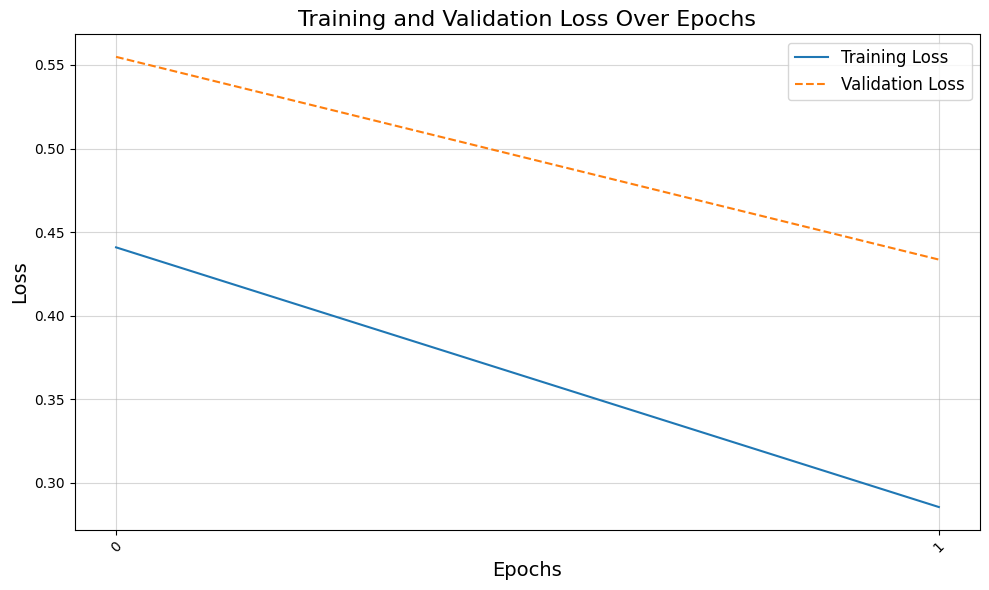

In [69]:
# Plot training and validation losses, if the evaluation frequency is 1
if evaluattion_frequency_in_epochs == 1:
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, len(all_training_losses)), all_training_losses, label='Training Loss', linestyle='-')
    plt.plot(range(0, len(all_validation_losses)), all_validation_losses, label='Validation Loss', linestyle='--')
    
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    # display 10 epochs or all (if len(all_validation_losses)//10) < 0) in the xticks
    plt.xticks(range(0, len(all_validation_losses), max(1, len(all_validation_losses)//10 )), rotation=45)  

    # Save the plot
    output_file = f"{output_folder}/plot-train_vs_evaluation_loss-{model_name}.png"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)  # Save the plot with tight layout and high resolution
    
    plt.tight_layout()
    plt.show()

In [70]:
# empty cache
if device.type == "cuda":
    torch.cuda.empty_cache()

In [103]:
# Evaluate on test data
# load best model
model = None
model = PhysicsformerModel(use_physics=use_physics, use_ml=use_ml)

model.load_state_dict(torch.load(f"{output_folder}/model-{model_name}-minimum_eval_loss-epoch-{best_model_epoch}.pth"))  
# model = torch.load(selected_model_location, map_location=device)
print(f"Loaded model")
model = model.to(device)

model.eval()

# define additional metrics
mse_loss_function = torch.nn.functional.mse_loss
mae_loss_function = torch.nn.functional.l1_loss

# get also the prediction for the data in each dataloader. Remember, each dataloader has batched data from one file of the dataset.
lst_all_loader_predictions = []    # each element contains predictions for 1 file of the dataset.
test_loss = 0.0
test_mse_loss = 0.0
test_mae_loss = 0.0
with torch.no_grad():
    for test_loader in test_loaders:
        lst_loader_predictions = []    # each element of this list has predictions for one batch
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.unsqueeze(2)  # Add batch dimension, to match the dimensionality of the model output.
        
            # predictions = model(X_batch)
            # test_loss += loss_function(predictions, y_batch).item()

            # # calculate additional metrics
            # test_mse_loss += mse_loss_function(predictions, y_batch).item()
            # test_mae_loss += mae_loss_function(predictions, y_batch).item()

            if HYBRYD_MODEL or (use_physics ^ use_ml):
                predictions = model.forward(X_batch)
                test_loss += loss_function(predictions, y_batch).item()

                # calculate additional metrics
                test_mse_loss += mse_loss_function(predictions, y_batch).item()
                test_mae_loss += mae_loss_function(predictions, y_batch).item()
            else:
                predictions = model.forward(X_batch)
                prediction_ml = predictions[0]
                prediction_ml = prediction_ml.unsqueeze(0)    # Add 1 dimension
                prediction_physics = predictions[1]
                prediction_physics = prediction_physics.unsqueeze(0)    # Add 1 dimension
                test_loss += ( loss_function(prediction_ml, y_batch) + \
                            (lambda_ * loss_function(prediction_physics, prediction_ml)) ).item()

                # calculate additional metrics
                test_mse_loss += ( mse_loss_function(prediction_ml, y_batch) + \
                        (lambda_ * mse_loss_function(prediction_physics, prediction_ml)) ).item()
                test_mae_loss += ( mae_loss_function(prediction_ml, y_batch) + \
                        (lambda_ * mae_loss_function(prediction_physics, prediction_ml)) ).item()
                
            # save predictions
            if HYBRYD_MODEL or (use_physics ^ use_ml):
                lst_loader_predictions.extend(predictions)    
            else:
                predictions_to_store = predictions[0].unsqueeze(0)    # Add 1 dimension
                lst_loader_predictions.extend(predictions_to_store)
    
        # save predictions of the corresponding test_loader, since it has the prediction for one file of the dataset
        lst_all_loader_predictions.append(lst_loader_predictions)

# print main loss
avg_test_loss = test_loss / n_test_batches
print(f"Test Loss (RMSE) - Metric used for training: {avg_test_loss:.6f}")

# print additional metrics
avg_mse_loss = test_mse_loss / n_test_batches
avg_mae_loss = test_mae_loss / n_test_batches
print(f"Test Loss (MSE): {avg_mse_loss:.6f}")
print(f"Test Loss (MAE): {avg_mae_loss:.6f}")

Loaded model
Test Loss (RMSE) - Metric used for training: 0.311175
Test Loss (MSE): 0.254469
Test Loss (MAE): 0.291157


In [104]:
lst_all_loader_predictions[0]

[tensor([[-1.6310]], device='cuda:0'),
 tensor([[-1.6310]], device='cuda:0'),
 tensor([[-1.6312]], device='cuda:0'),
 tensor([[-1.6314]], device='cuda:0'),
 tensor([[-1.6317]], device='cuda:0'),
 tensor([[-1.6319]], device='cuda:0'),
 tensor([[-1.6326]], device='cuda:0'),
 tensor([[-1.6337]], device='cuda:0'),
 tensor([[-1.6334]], device='cuda:0'),
 tensor([[-1.6323]], device='cuda:0'),
 tensor([[-1.6335]], device='cuda:0'),
 tensor([[-1.6364]], device='cuda:0'),
 tensor([[-1.6367]], device='cuda:0'),
 tensor([[-1.6356]], device='cuda:0'),
 tensor([[-1.6362]], device='cuda:0'),
 tensor([[-1.6379]], device='cuda:0'),
 tensor([[-1.6382]], device='cuda:0'),
 tensor([[-1.6376]], device='cuda:0'),
 tensor([[-1.6377]], device='cuda:0'),
 tensor([[-1.6382]], device='cuda:0'),
 tensor([[-1.6391]], device='cuda:0'),
 tensor([[-1.6400]], device='cuda:0'),
 tensor([[-1.6405]], device='cuda:0'),
 tensor([[-1.6408]], device='cuda:0'),
 tensor([[-1.6409]], device='cuda:0'),
 tensor([[-1.6410]], devi

In [108]:
# flattened_list = [[tensor.item() for tensor in tensor_list] for tensor_list in lst_all_loader_predictions]
flattened_list = [[tensor.item() for tensor in tensor_list] for tensor_list in lst_all_loader_predictions]
# np.array(predictions).reshape(-1, 1)
# add dimenstion to predictions
flattened_list = [np.array(list_).reshape(-1, 1) for list_ in flattened_list]
flattened_list[0]

array([[-1.63100386],
       [-1.6310246 ],
       [-1.63116336],
       ...,
       [-2.18366265],
       [-2.18354869],
       [-2.18347096]])

In [73]:
# Prepare model output to store it as additional column in test set data.

In [109]:
# convert lst_all_loader_predictions into NumPy arrays
# lst_all_loader_predictions = [
#     t.cpu().detach().numpy() for sublist in lst_all_loader_predictions for t in sublist
# ]

lst_all_loader_predictions = [[tensor.item() for tensor in tensor_list] for tensor_list in lst_all_loader_predictions]
# add dimenstion to predictions
lst_all_loader_predictions = [np.array(list_).reshape(-1, 1) for list_ in lst_all_loader_predictions]

# inverse_transform the scaling of the y_predicted values
lst_all_loader_predictions = [scaler_y.inverse_transform(predictions) for predictions in lst_all_loader_predictions]

In [110]:
lst_all_loader_predictions[0]

array([[45.49325296],
       [45.49297377],
       [45.4911061 ],
       ...,
       [38.05457199],
       [38.05610592],
       [38.05715208]])

In [111]:
# save X_test, y_test and model predictions together in files

files_data = []    # each dataloader has batched data of 1 file of the (test) dataset, which will be stored here. So each element of this list is 1 file.
for idx_dataloader in range(len(test_loaders)):
    file_data = []    # each element is one batch of the file
    
    for X_batch, y_batch in test_loaders[idx_dataloader]:
        # combine X, y and  data to have everything in one list
        X_data = scaler_X.inverse_transform(X_batch.cpu().numpy())
        y_data = scaler_y.inverse_transform(y_batch.cpu().numpy())
        X_and_y = [list(l1) + list(l2) for l1, l2 in zip(X_data, y_data)]
    
        file_data.extend(X_and_y)

    file_data = np.array(file_data)
    file_predictions_array = np.array(lst_all_loader_predictions[idx_dataloader])
    file_data = [list(l1) + list(l2) for l1, l2 in zip(file_data, file_predictions_array)]
        
    files_data.append(file_data)

    # break

In [112]:
files_data[0]

[[-1.667699e-05,
  31.500002,
  188000.0,
  366.7,
  -11.400001,
  11.0,
  -7.1961694e-09,
  31.5,
  45.49325296288799],
 [0.09995891,
  31.500002,
  188000.0,
  366.7,
  -11.400001,
  11.0,
  0.1,
  31.5,
  45.49297377395786],
 [0.1999345,
  31.500002,
  188000.0,
  366.67,
  -11.84,
  11.0,
  0.1,
  31.5,
  45.49110609628727],
 [0.30003214,
  31.500002,
  188000.0,
  366.62,
  -12.54,
  11.0,
  0.1,
  31.5,
  45.487669184285195],
 [0.40000772,
  31.500002,
  188000.0,
  366.6,
  -12.71,
  11.0,
  0.1,
  31.5,
  45.48432854432801],
 [0.4999833,
  31.500002,
  188000.0,
  366.6,
  -12.559999,
  11.0,
  0.1,
  31.5,
  45.481555909435585],
 [0.60008097,
  31.500002,
  188000.0,
  366.57,
  -12.5,
  11.0,
  0.1,
  31.5,
  45.471509921552794],
 [0.70005655,
  31.500002,
  188000.0,
  366.52,
  -12.5,
  11.0,
  0.1,
  31.5,
  45.45668723571007],
 [0.79991007,
  31.500002,
  188000.0,
  366.5,
  -13.099999,
  11.0,
  0.1,
  31.5,
  45.460542931107355],
 [0.9000077,
  31.500002,
  188000.0,
 

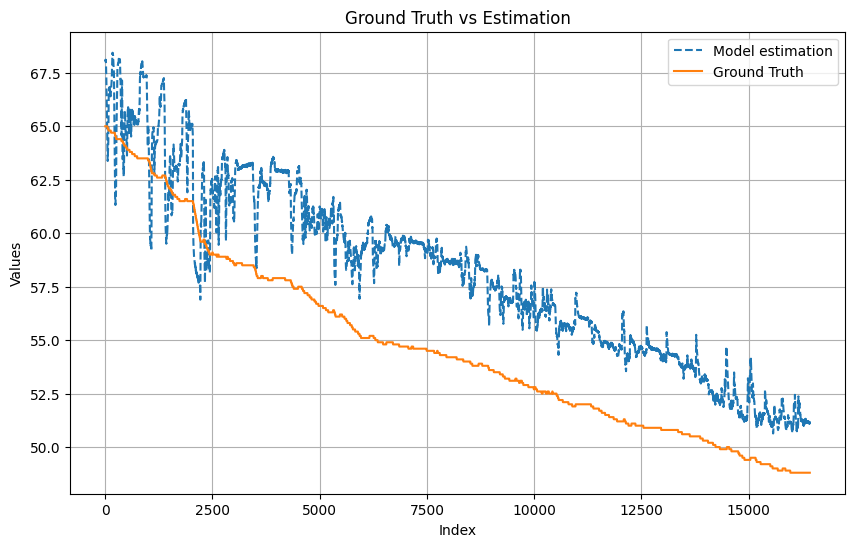

In [122]:
# plot ground truth vs model Estimation of one test file

data = files_data[9]

# Extracting the last and second last elements of each sublist
last_elements = [row[-1] for row in data]
second_last_elements = [row[-2] for row in data]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(last_elements, label="Model estimation", linestyle='dashed')
plt.plot(second_last_elements, label="Ground Truth")

# Adding labels, title, and legend
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Ground Truth vs Estimation")
plt.legend()
plt.grid()

# Display the plot
plt.show()

## Store model and test results

In [79]:
# store each element of files_data as csv file

# Create folder (if it doesn't exist) to store test predictions and X and y features
output_folder_test_files = f"{output_folder}/test_data_and_model_output"
os.makedirs(output_folder_test_files, exist_ok=True)

# create column name for model output
estimation_column_name = f"""{'Physics' if model.use_physics else ''}{'-and-' if model.use_physics and model.use_ml else ''}{'Transformer' if model.use_ml else ''}"""

for idx_file_data in range(len(files_data)):
    file_data = files_data[idx_file_data]

    # create df
    columns = list(X_column_names.copy())

    columns.extend(["SoC [%]", estimation_column_name])
    # columns = ["Time [s]", "SoC_0", "Q_rated", "Battery Voltage [V]", "Battery Current [A]", "Time_difference", "SoC [%]", "Estimated SoC (Transformer model)"]
    df = pd.DataFrame(file_data, columns=columns)

    # save in created folder
    output_file = f"file-{idx_file_data}.csv"
    output_file = os.path.join(output_folder_test_files,output_file)
    df.to_csv(output_file, index=True, sep=";", encoding="ISO-8859-2")


In [80]:
# export hyperparameters and other relevant variables
hyperparameters_and_other_relevant_variables = {
    "model_name": model_name,
    "NORMALIZE_DATA": NORMALIZE_DATA,
    "BATCH_SIZE": BATCH_SIZE,
    "ML_MODEL_USES_CALCULATED_COLUMNS": ML_MODEL_USES_CALCULATED_COLUMNS,
    "dataset_folder": dataset_folder,
    "required_columns": required_columns,
    "calculated_columns": calculated_columns,
    "device": torch.cuda.get_device_name(device),
    "d_model": d_model,
    "num_heads": num_heads,
    "num_layers": num_layers,
    "dropout": dropout,
    "dim_feedforward": dim_feedforward,
    "input_dim": input_dim,
    "output_dim": output_dim,
    "use_physics": use_physics,
    "use_ml": use_ml,
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "patience": patience,
    "evaluattion_frequency_in_epochs": evaluattion_frequency_in_epochs,
    "HYBRYD_MODEL": HYBRYD_MODEL,
}


with open(f"{output_folder}/hyperparameters_and_relevant_variables.json", 'w') as file:
    json.dump(hyperparameters_and_other_relevant_variables, file)

In [81]:
# export metrics
metrics = {
    "validation set RMSE": all_validation_rmses[best_model_epoch],
    "test set loss (RMSE)": avg_test_loss,
    "test set loss (MSE)": avg_mse_loss,
    "test set loss (MAE)": avg_mae_loss,
}

with open(f"{output_folder}/metrics.json", 'w') as file:
    json.dump(metrics, file)

## Empty cuda cache if necessary

In [82]:
if device.type == "cuda":
    torch.cuda.empty_cache()